In [ ]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit_textbook.tools import vector2latex

# import basic plot tools
from qiskit.visualization import plot_histogram

## Ex 1

The difference between solution from homework and solution from qiskit is how they create oracle.

In homework it was a "classic" Oracle whereas in qiskit the oracle returns |x> if x is != |w> and -|x> is |w>.

### Homework

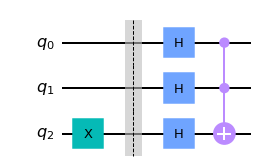

In [30]:
qc = QuantumCircuit(3)
qc.x(2)
qc.barrier()

# s
qc.h(0)
qc.h(1)
qc.h(2)

# oracle
qc.ccx(0, 1, 2)

qc.draw()

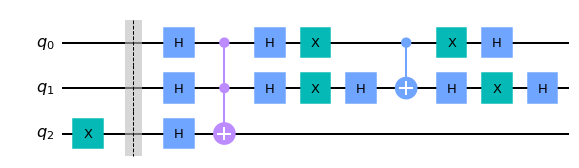

In [31]:


qc.h(0)
qc.h(1)

qc.x(0)
qc.x(1)

qc.h(1)
qc.cx(0, 1)
qc.h(1)

qc.x(0)
qc.x(1)

qc.h(0)
qc.h(1)

qc.draw()

In [32]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
qc_sim = qc.copy()
qc_sim.save_statevector()
qobj = assemble(qc_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()

vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

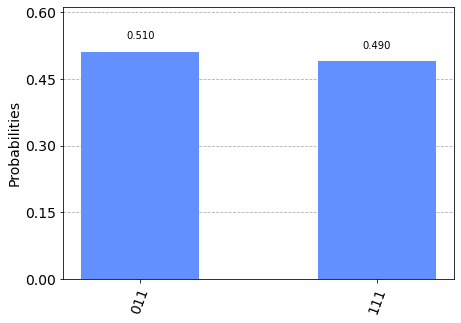

In [33]:
qc.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

### Qiskit

In [101]:
n = 2
grover_circuit = QuantumCircuit(n)

In [102]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

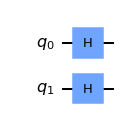

In [103]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

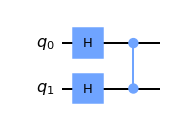

In [104]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

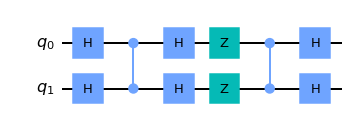

In [105]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

In [106]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()

vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

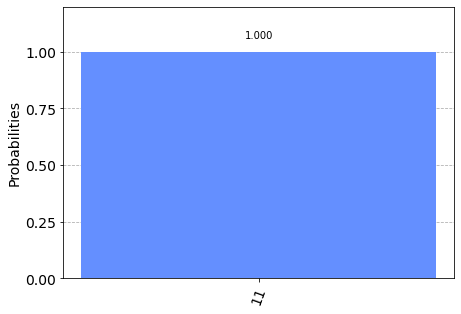

In [107]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [108]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2022-06-04 13:21:37,191: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_santiago


In [109]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


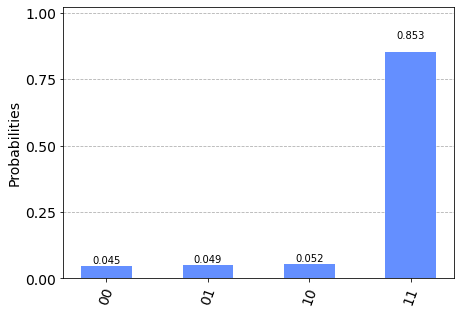

In [110]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

## Lab 11 - Error Mitigation

In [123]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

cal_circuits, state_labels = complete_meas_cal(qr=grover_circuit.qregs[0], circlabel='mcal')

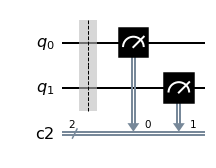

In [124]:
cal_circuits[0].draw()

In [125]:
from qiskit import execute

cal_job = execute(
    cal_circuits, 
    backend=device,
    shots=1024,
    optimization_level=0
)

print(cal_job.job_id())

job_monitor(cal_job)
cal_results = cal_job.result()

629b6efa7fc73d64991c9a5f
Job Status: job has successfully run


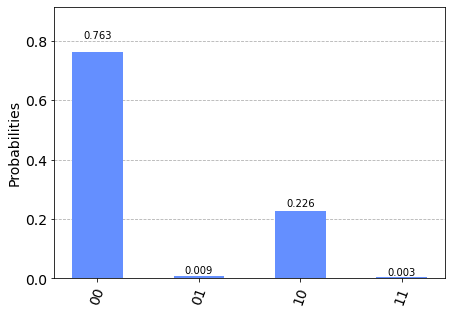

In [126]:
plot_histogram(
    cal_results.get_counts(cal_circuits[0])
)

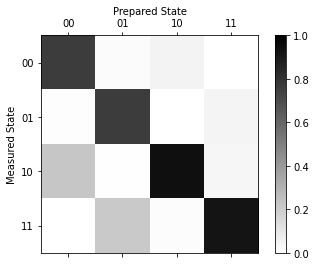

In [127]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

In [128]:
meas_filter = meas_fitter.filter

In [129]:
mitigated_result = meas_filter.apply(results)

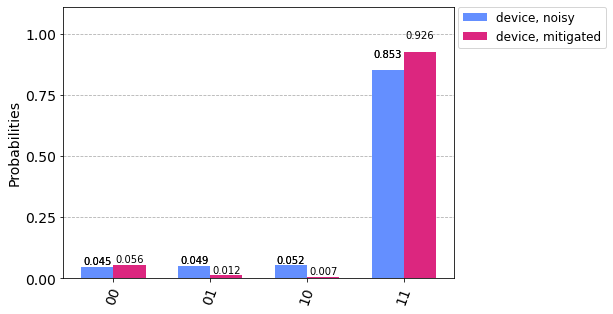

In [131]:
device_counts = results.get_counts(grover_circuit)
mitigated_counts = mitigated_result.get_counts(grover_circuit)

plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

## Exercise 2

The reason I chose a solution from qiskit is that it's every easy 
to create the oracle, here's one for |000>.


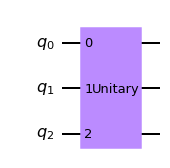

In [99]:
from qiskit.quantum_info.operators import Operator
qc = QuantumCircuit(3)

oracle = Operator([
    [-1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
])

qc.unitary(oracle, [0, 1, 2])

oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

qc.draw()

In [94]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

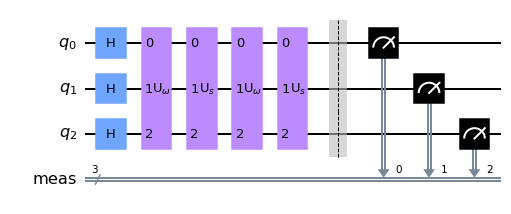

In [97]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])

# after one step
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])

# after two steps
# grover_circuit.append(oracle_ex3, [0,1,2])
# grover_circuit.append(diffuser(n), [0,1,2])

# after three steps
# grover_circuit.append(oracle_ex3, [0,1,2])
# grover_circuit.append(diffuser(n), [0,1,2])

grover_circuit.measure_all()
grover_circuit.draw()

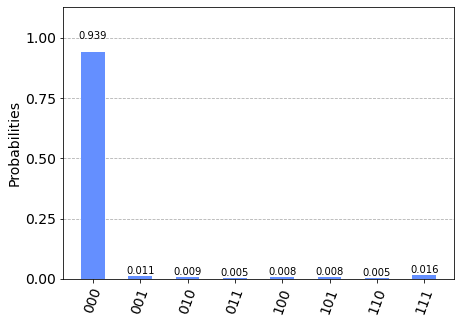

In [98]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [100]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job is queued (8)     

KeyboardInterrupt: 

In [ ]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)